In [1]:
%pip install starsim

Looking in indexes: https://pypi.org/simple, https://artifactory.ihme.washington.edu/artifactory/api/pypi/pypi-shared/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import starsim as ss

# Understanding basic StarSim

/home/abie/miniforge3/lib/python3.12/site-packages/starsim/time.py:118: FutureWarning: sc.datetoyear() argument "reverse" has been deprecated as of v3.2.1; use sc.yeartodate() instead
  datevec = np.array([date(sc.datetoyear(y, reverse=True)) for y in yearvec])


Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.08 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.16 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.21 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.29 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.33 s)  •••••••••••••••••••• 100%

Figure(800x600)


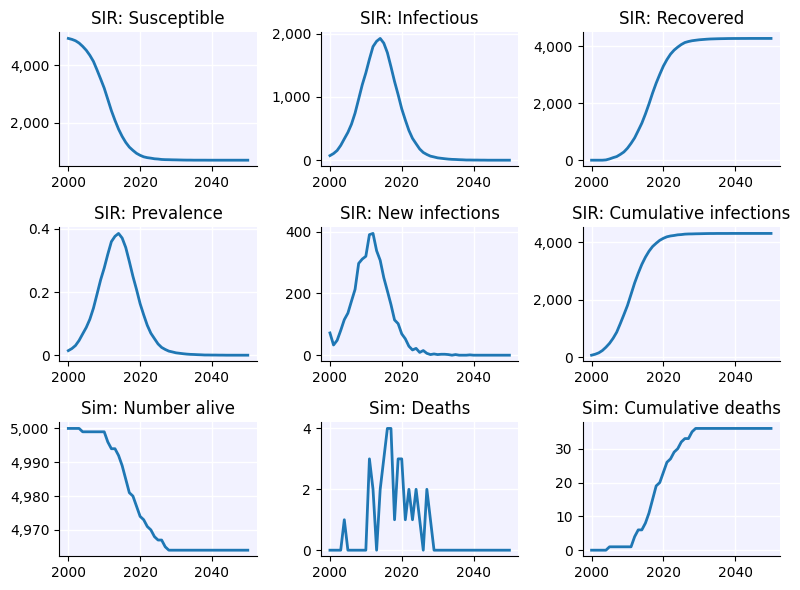

Figure(640x480)


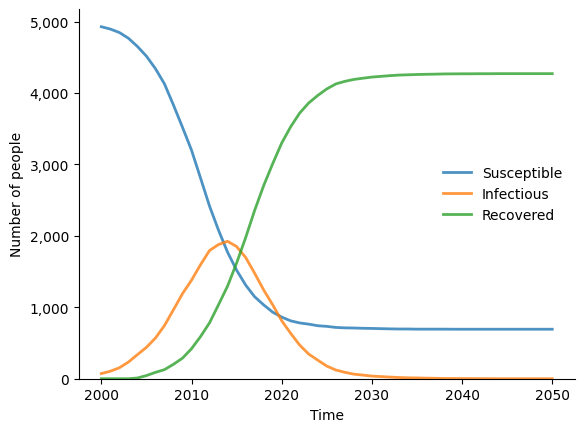

In [3]:
# Define the parameters
pars = dict(
    n_agents = 5_000,     # Number of agents to simulate
    networks = dict(      # Networks define how agents interact w/ each other
        type = 'random',  # Here, we use a 'random' network
        n_contacts = 10   # Each person has 10 contacts with other people
    ),
    diseases = dict(      # *Diseases* add detail on what diseases to model
        type = 'sir',     # Here, we're creating an SIR disease
        init_prev = 0.01, # Proportion of the population initially infected
        beta = 0.05,      # Probability of transmission between contacts
        dur_inf = 5,      # Duration of infection in years
    )
)
# Make the sim, run and plot
sim = ss.Sim(pars)
sim.run()
sim.plot()
sim.diseases.sir.plot()

# Demonstrating that we understand SIR model

We worked together to understand what is happening here; every timestep simulants contact their neighbors in the network, and if a neighbor is infectious, the infection is transmitted with probability beta (note the non-standard definition of beta).  When infected, a simulant has a mean duration before recovering, and therefore the expected number of infections is `n_contacts * beta * dur_inf`.



/home/abie/miniforge3/lib/python3.12/site-packages/starsim/time.py:118: FutureWarning: sc.datetoyear() argument "reverse" has been deprecated as of v3.2.1; use sc.yeartodate() instead
  datevec = np.array([date(sc.datetoyear(y, reverse=True)) for y in yearvec])


Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.06 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.12 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.18 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.22 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.27 s)  •••••••••••••••••••• 100%

Figure(800x600)


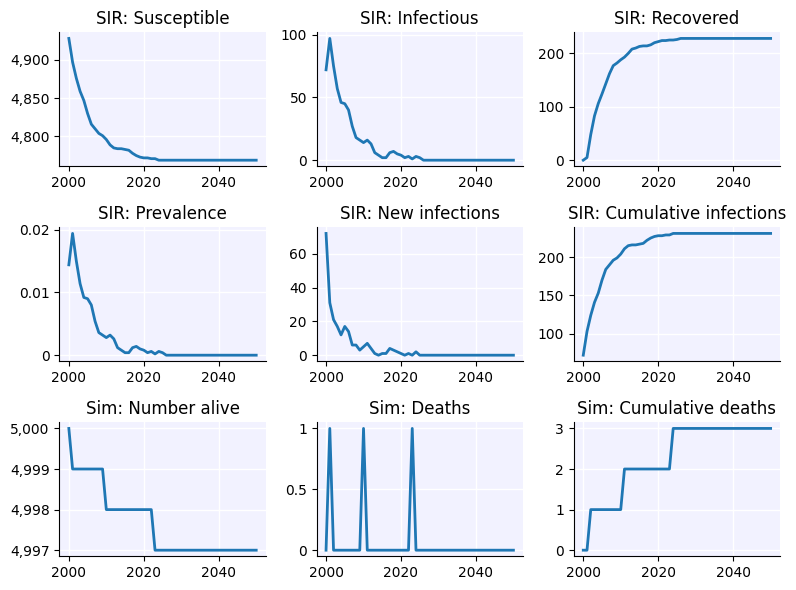

Figure(640x480)


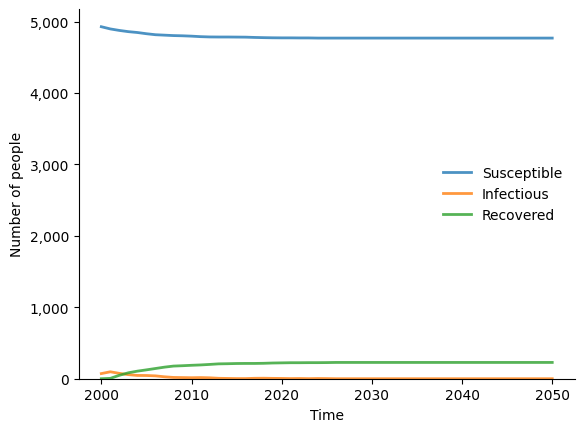

In [4]:
# example of R0 = 1.0 --- 
pars = dict(
    n_agents = 5_000,     # Number of agents to simulate
    networks = dict(      # Networks define how agents interact w/ each other
        type = 'random',  # Here, we use a 'random' network
        n_contacts = 10   # Each person has 10 contacts with other people
    ),
    diseases = dict(      # *Diseases* add detail on what diseases to model
        type = 'sir',     # Here, we're creating an SIR disease
        init_prev = 0.01, # Proportion of the population initially infected
        beta = 0.05,      # Probability of transmission between contacts
        dur_inf = 2,      # Duration of infection in years
    )
)
# Make the sim, run and plot
sim = ss.Sim(pars)
sim.run()
sim.plot()
sim.diseases.sir.plot()

# Mini-project: SEIR Simulator

- Implement basic SEIR model using StarSim
- Plot epidemic curves for 3 different R₀ values (1.2, 2.5, 4.0)
- Calculate peak timing and final attack rate for each scenario

# StarSim does not have an SEIR model built in

But it does have an example of how to make one as [a developer tutorial](https://docs.idmod.org/projects/starsim/en/stable/tutorials/dev_tut_diseases.html#Making-your-own-disease).

In [5]:
class SEIR(ss.SIR):
    def __init__(self, pars=None, *args, **kwargs):
        super().__init__()
        self.define_pars(
            dur_exp = ss.lognorm_ex(0.5),
        )
        self.update_pars(pars, **kwargs)

        # Additional states beyond the SIR ones
        self.define_states(
            ss.State('exposed', label='Exposed'),
            ss.FloatArr('ti_exposed', label='TIme of exposure'),
        )
        return

    @property
    def infectious(self):
        return self.infected | self.exposed

    def step_state(self):
        """ Make all the updates from the SIR model """
        # Perform SIR updates
        super().step_state()

        # Additional updates: progress exposed -> infected
        infected = self.exposed & (self.ti_infected <= self.ti)
        self.exposed[infected] = False
        self.infected[infected] = True
        return

    def step_die(self, uids):
        super().step_die(uids)
        self.exposed[uids] = False
        return

    def set_prognoses(self, uids, sources=None):
        """ Carry out state changes associated with infection """
        super().set_prognoses(uids, sources)
        ti = self.ti
        self.susceptible[uids] = False
        self.exposed[uids] = True
        self.ti_exposed[uids] = ti

        # Calculate and schedule future outcomes
        dur_exp = self.pars['dur_exp'].rvs(uids)
        self.ti_infected[uids] = ti + dur_exp
        dur_inf = self.pars['dur_inf'].rvs(uids)
        will_die = self.pars['p_death'].rvs(uids)
        self.ti_recovered[uids[~will_die]] = ti + dur_inf[~will_die]
        self.ti_dead[uids[will_die]] = ti + dur_inf[will_die]

        # Update result count of new infections
        self.results['new_infections'][self.ti] += len(uids)
        return

    def plot(self):
        """ Update the plot with the exposed compartment """
        with ss.options.context(jupyter=False):
            fig = super().plot()
            ax = plt.gca()
            res = self.results.n_exposed
            ax.plot(res.timevec, res, label=res.label)
            plt.legend()
        return ss.return_fig(fig)

/home/abie/miniforge3/lib/python3.12/site-packages/starsim/time.py:118: FutureWarning: sc.datetoyear() argument "reverse" has been deprecated as of v3.2.1; use sc.yeartodate() instead
  datevec = np.array([date(sc.datetoyear(y, reverse=True)) for y in yearvec])


Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.07 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.13 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.19 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.25 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.30 s)  •••••••••••••••••••• 100%

Figure(640x480)


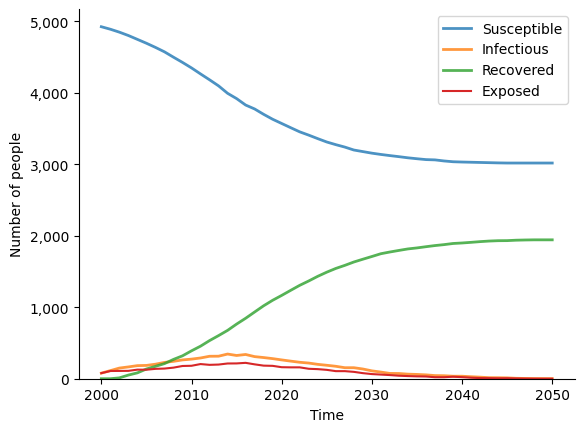

In [6]:
seir = SEIR(dict(
        init_prev = 0.01, # Proportion of the population initially infected
        beta = 1.2/3/10,      # Probability of transmission between contacts
        dur_exp = 2,      # Duration of exposure in years
        dur_inf = 3,      # Duration of infection in years
    ))
pars = dict(
    n_agents = 5_000,     # Number of agents to simulate
    networks = dict(      # Networks define how agents interact w/ each other
        type = 'random',  # Here, we use a 'random' network
        n_contacts = 10   # Each person has 10 contacts with other people
    )
)

sim = ss.Sim(pars, diseases=seir)
sim.run()
sim.diseases.seir.plot()

/home/abie/miniforge3/lib/python3.12/site-packages/starsim/time.py:118: FutureWarning: sc.datetoyear() argument "reverse" has been deprecated as of v3.2.1; use sc.yeartodate() instead
  datevec = np.array([date(sc.datetoyear(y, reverse=True)) for y in yearvec])


Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.07 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.13 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.19 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.24 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.29 s)  •••••••••••••••••••• 100%

Figure(640x480)


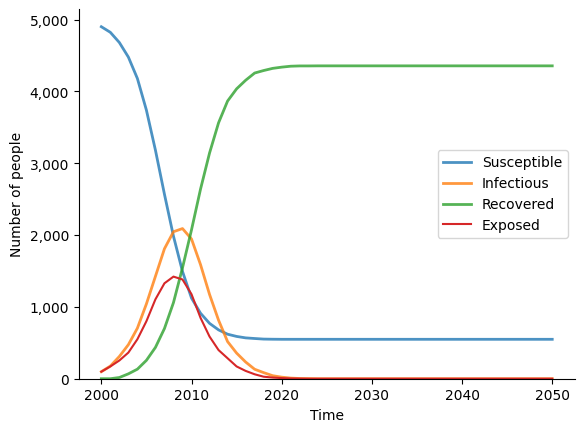

In [7]:
seir = SEIR(dict(
        init_prev = 0.01, # Proportion of the population initially infected
        beta = 2.5/3/10,      # Probability of transmission between contacts
        dur_exp = 2,      # Duration of exposure in years
        dur_inf = 3,      # Duration of infection in years
    ))
sim = ss.Sim(pars, diseases=seir)
sim.run()
sim.diseases.seir.plot()

/home/abie/miniforge3/lib/python3.12/site-packages/starsim/time.py:118: FutureWarning: sc.datetoyear() argument "reverse" has been deprecated as of v3.2.1; use sc.yeartodate() instead
  datevec = np.array([date(sc.datetoyear(y, reverse=True)) for y in yearvec])


Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (0.00 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (0.07 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (0.12 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (0.17 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (0.22 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (0.26 s)  •••••••••••••••••••• 100%

Figure(640x480)


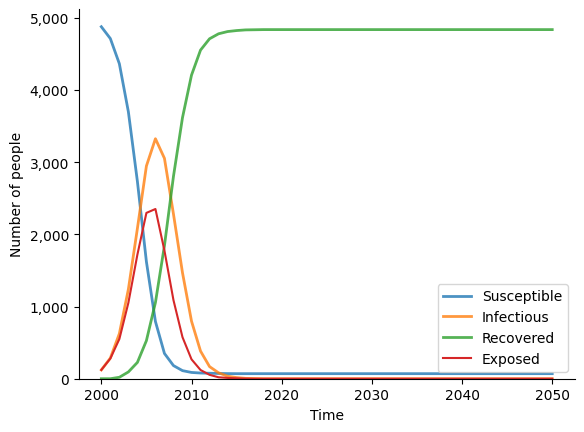

In [8]:
seir = SEIR(dict(
        init_prev = 0.01, # Proportion of the population initially infected
        beta = 4.0/3/10,      # Probability of transmission between contacts
        dur_exp = 2,      # Duration of exposure in years
        dur_inf = 3,      # Duration of infection in years
    ))
sim = ss.Sim(pars, diseases=seir)
sim.run()
sim.diseases.seir.plot()

# Calculate peak timing and final attack rate for each scenario

The final attack ratio is the proportion
of the population that gets infected by the end of the epidemic.

In [9]:
sim.results

Results(sim)
0. timevec: array(start=2000.0, stop=2050.0)
1. randomnet: Results(randomnet)
    1.0. timevec: array(start=2000.0, stop=2050.0)
    1.1. n_edges: Result(min=24540, mean=24622, max=25000)
2. seir: Results(seir)
    2.0. timevec: array(start=2000.0, stop=2050.0)
    2.1. n_susceptible: Result(min=70, mean=516.765, max=4878)
    2.2. n_infected: Result(min=0, mean=371.059, max=3326)
    2.3. n_recovered: Result(min=0, mean=4066.75, max=4838)
    2.4. n_exposed: Result(min=0, mean=241.118, max=2352)
    2.5. prevalence: Result(min=0, mean=0.074662, max=0.668006)
    2.6. new_infections: Result(min=0, mean=96.5098, max=955)
    2.7. cum_infections: Result(min=0, mean=4284.9, max=4922)
3. n_alive: Result(min=4908, mean=4922.59, max=5000)
4. new_deaths: Result(min=0, mean=1.80392, max=18)
5. cum_deaths: Result(min=0, mean=75.6078, max=92)

In [10]:
s_infected = pd.Series(sim.results.seir.n_infected, index=sim.results.seir.timevec)  # pd.Series of number infected, indexed by time
s_infected.sort_values(ascending=False).iloc[[0]]  # time and value of time with most infected

2006.0    3326.0
dtype: float64

In [11]:
np.round(100 * sim.results.seir.cum_infections / 10_000, 1)  # percent infected over time; when it stops changing that is the final attack rate

array([ 0. ,  0.3,  1.5,  3.8,  7.8, 14.4, 23.9, 33.5, 40.6, 45. , 47.2,
       48.3, 48.8, 49.1, 49.1, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2,
       49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2,
       49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2,
       49.2, 49.2, 49.2, 49.2, 49.2, 49.2, 49.2])